# Stocks Price Prediction

In [50]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# function to download and save the raw data
def get_data(ticker, start, end):
    raw_data = yf.download(ticker, start, end)
    os.makedirs(f"../datasets/{ticker}", exist_ok=True)
    raw_data.to_csv(f"../datasets/{ticker}/raw.csv")
    return raw_data

In [24]:
ticker = "GOOG"
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)
print(start)

2015-09-09 00:00:00


In [25]:
# downloading the data
raw_data = get_data(ticker, start, end)
raw_data.head()

/tmp/ipykernel_16703/1084484216.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2015-09-09,30.427773,31.113083,30.272833,30.849885,34042000
2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000
2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000
2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000
2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000


In [26]:
# quick clean up
def clean_up(data):
    clean_data = data.copy()
    clean_data.columns = clean_data.columns.get_level_values(0)
    clean_data.columns.name = None
    clean_data.to_csv(f"../datasets/{ticker}/clean.csv")

clean_up(raw_data)

In [27]:
data = pd.read_csv(f"../datasets/{ticker}/clean.csv")
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-09,30.427773,31.113083,30.272833,30.849885,34042000
1,2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000
2,2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000
3,2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000
5,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000
6,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000
7,2015-09-18,31.248659,31.782506,31.137917,31.623098,102668000
8,2015-09-21,31.556053,31.608196,31.084283,31.504407,35770000
9,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000


In [28]:
data.shape

(2514, 6)

In [29]:
data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [30]:
data.duplicated().sum()

np.int64(0)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2514 non-null   object 
 1   Close   2514 non-null   float64
 2   High    2514 non-null   float64
 3   Low     2514 non-null   float64
 4   Open    2514 non-null   float64
 5   Volume  2514 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 118.0+ KB


In [32]:
data.tail(10)

,Date,Close,High,Low,Open,Volume
2504,2025-08-25,208.973221,210.901490,205.766081,206.815146,22788800
2505,2025-08-26,207.764297,208.273852,206.265637,208.183921,23051000
2506,2025-08-27,208.024078,209.382865,206.205696,206.275641,15249000
2507,2025-08-28,212.180344,212.709869,207.414614,207.654390,20915700
2508,2025-08-29,213.339310,215.147691,210.781598,211.081333,24682200
2509,2025-09-02,211.800705,212.179364,206.775198,208.803384,28900100
2510,2025-09-03,230.893631,231.593003,224.918960,226.277746,72250300
2511,2025-09-04,232.452240,232.562142,226.557499,229.949472,32196000
2512,2025-09-05,234.959991,235.919141,232.172490,232.452238,26127700
2513,2025-09-08,234.160004,238.399994,233.729996,235.789993,23104200


In [33]:
data.describe()

,Close,High,Low,Open,Volume
count,2514.000000,2514.000000,2514.000000,2514.000000,2.514000e+03
mean,92.621215,93.580157,91.620770,92.557377,2.956575e+07
std,48.223139,48.760893,47.671240,48.186284,1.417169e+07
min,29.542336,30.044399,29.268709,29.661023,6.809800e+06
25%,52.058875,52.671923,51.346371,52.094501,2.065125e+07
50%,75.555946,77.492699,75.004226,75.737952,2.613900e+07
75%,133.368340,134.884799,131.979342,133.317186,3.409300e+07
max,234.959991,238.399994,233.729996,235.789993,1.330780e+08


In [34]:
data["Date"] = pd.to_datetime(data["Date"])
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-09,30.427773,31.113083,30.272833,30.849885,34042000
1,2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000
2,2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000
3,2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000
5,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000
6,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000
7,2015-09-18,31.248659,31.782506,31.137917,31.623098,102668000
8,2015-09-21,31.556053,31.608196,31.084283,31.504407,35770000
9,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000


In [35]:
# creating subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.2
)

# candle stick chart
fig.add_trace(go.Candlestick(
    x = data["Date"],
    open = data["Open"],
    high = data["High"],
    low = data["Low"],
    close = data["Close"],
    name = "Price"
    ),
    row=1, col=1
)

# volume bars
fig.add_trace(go.Bar(
    x = data["Date"],
    y = data["Volume"],
    name = "volume",
    marker_color="#c1440e",
    opacity=1.0,
    ),
    row=2, col=1
)

# layout
fig.update_layout(
    title = "Candlesticks Chart With Volume",
    xaxis_rangeslider_visible = False,
    xaxis_title="Date",
    yaxis_title="Price",
    yaxis2_title="Volume",
    template="plotly_dark",
    showlegend = False,
    height=900
)

fig.show()

In [36]:
# adding log returns
data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns
0,2015-09-09,30.427773,31.113083,30.272833,30.849885,34042000,NaN
1,2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000,0.013986
2,2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000,0.007088
3,2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000,-0.004051
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914
5,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322
6,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822
7,2015-09-18,31.248659,31.782506,31.137917,31.623098,102668000,-0.021461
8,2015-09-21,31.556053,31.608196,31.084283,31.504407,35770000,0.009789
9,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000,-0.020269


In [37]:
data["Log_Returns"].isnull().sum()

np.int64(1)

In [38]:
data.shape

(2514, 7)

In [39]:
data.sample(10)

,Date,Close,High,Low,Open,Volume,Log_Returns
202,2016-06-28,33.770897,33.785298,33.421292,33.717763,43476000,0.017474
1937,2023-05-19,122.412292,125.619342,121.885896,123.355832,30268900,-0.002188
414,2017-05-02,45.510559,45.725591,45.163584,45.171877,31744000,0.004232
789,2018-10-25,54.406181,55.171445,53.114025,53.225264,50916000,0.041809
1090,2020-01-08,69.738770,70.099301,69.069347,69.130922,30560000,0.007850
1883,2023-03-03,93.380966,93.470358,92.030217,92.109667,30242500,0.018355
1141,2020-03-23,52.471924,53.201929,50.332364,52.705327,80882000,-0.014749
972,2019-07-22,56.516743,56.575344,55.829945,56.287314,26030000,0.007028
1922,2023-04-28,107.484451,107.553975,105.319268,107.067308,23957900,-0.001385
1080,2019-12-23,66.983612,67.527884,66.867903,67.332724,17662000,-0.000556


In [40]:
data = data.dropna()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns
1,2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000,0.013986
2,2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000,0.007088
3,2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000,-0.004051
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914
5,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322
6,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822
7,2015-09-18,31.248659,31.782506,31.137917,31.623098,102668000,-0.021461
8,2015-09-21,31.556053,31.608196,31.084283,31.504407,35770000,0.009789
9,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000,-0.020269
10,2015-09-23,30.906500,31.232768,30.789302,30.891106,29418000,-0.000530


In [41]:
data.shape

(2513, 7)

In [42]:
stats = data["Log_Returns"].describe()
skewness = data["Log_Returns"].skew()
kurtosis = data["Log_Returns"].kurtosis()

In [43]:

print("Summary Stats:\n", stats)
print("\nSkewness:", skewness)
print("Kurtosis:", kurtosis)

Summary Stats:
 count    2513.000000
mean        0.000812
std         0.018052
min        -0.117667
25%        -0.007176
50%         0.001388
75%         0.010057
max         0.099379
Name: Log_Returns, dtype: float64

Skewness: -0.1877021265529996
Kurtosis: 4.766213774202224


In [44]:
# stationarity check
result = adfuller(data['Log_Returns'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -16.919043158207444
p-value: 9.972640774414808e-30
Critical Value 1%: -3.4329642237790847
Critical Value 5%: -2.862694950990622
Critical Value 10%: -2.5673848250020415


In [ ]:
# volatility visualization
window = 21
data['Rolling_Vol'] = data['Log_Returns'].rolling(window).std()
data.sample(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Rolling_Vol
1009,2019-09-12,61.293056,61.670967,60.735372,60.798937,34518000,0.011473,0.014747
1700,2022-06-09,114.136932,117.545605,114.086277,115.550757,23142000,-0.019987,0.023813
2354,2025-01-17,196.912308,198.168235,194.679533,197.410694,22109100,0.016022,0.015471
1857,2023-01-25,96.072548,97.055817,94.614523,96.539347,31000900,-0.025315,0.020994
1396,2021-03-26,101.085739,101.852495,100.016556,101.250119,29870000,-0.004319,0.017737
120,2016-03-02,35.698208,35.755316,35.358033,35.705657,32580000,0.000055,0.019020
942,2019-06-07,52.939716,53.182061,52.063711,52.174457,36048000,0.020566,0.020209
2227,2024-07-17,181.585190,184.180401,180.590856,183.633515,17376600,-0.015647,0.013742
1419,2021-04-29,120.668732,120.997976,119.297614,119.697382,39554000,0.020783,0.014680
2261,2024-09-04,156.915771,159.491092,156.547873,157.179269,17410700,-0.005057,0.014558


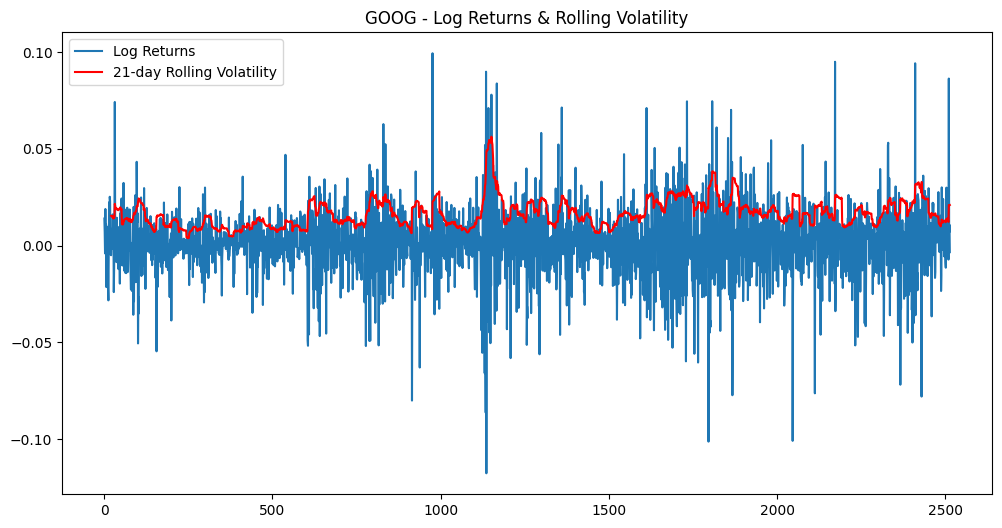

In [47]:
plt.figure(figsize=(12,6))
plt.plot(data['Log_Returns'], label='Log Returns')
plt.plot(data['Rolling_Vol'], label=f'{window}-day Rolling Volatility', color='red')
plt.legend()
plt.title(f"{ticker} - Log Returns & Rolling Volatility")
plt.show()

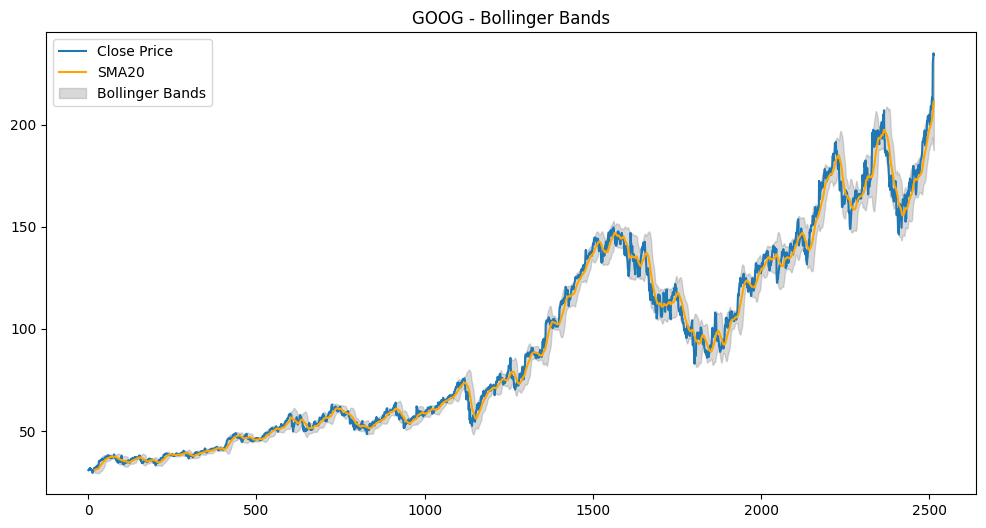

In [49]:
# bollinger bands
data['SMA20'] = data['Close'].rolling(20).mean()
data['Upper'] = data['SMA20'] + 2*data['Close'].rolling(20).std()
data['Lower'] = data['SMA20'] - 2*data['Close'].rolling(20).std()

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA20'], label='SMA20', color='orange')
plt.fill_between(data.index, data['Upper'], data['Lower'], color='gray', alpha=0.3, label='Bollinger Bands')
plt.legend()
plt.title(f"{ticker} - Bollinger Bands")
plt.show()

In [ ]:
# correlation analysis
plt.figure(figsize=(8,6))
sns.heatmap(data[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title(f"{ticker} - OHLCV Correlation Matrix")
plt.show()